<a href="https://colab.research.google.com/github/ReidelVichot/LC_identification/blob/main/AirQuality_PM122324.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting the Environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# -- Setting environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# -- Load county shapefiles
dir = "/content/drive/MyDrive/Disertation/countyshp/"
county = gpd.read_file(dir + "tl_2010_us_county00/tl_2010_us_county00.shp")
county = county[["CNTYIDFP00", "geometry"]]

Mounted at /content/drive


#Defining Functions

In [2]:
def gen_GEOID(df):
  # generate GEOID
  df["GEOID"] = df["State Code"].astype(str).str.zfill(2) + df["County Code"].astype(str).str.zfill(3)
  df = df.drop(columns=["State Code", "County Code"])
  return df

def gen_year(df):
  # get year
  df["year"] = df["Date"].str[:4].astype(int)
  df = df.drop(columns="Date")
  return df

def grouping(df):
  df = df.groupby(["GEOID", "year", 'Units of Measure']).agg(["mean", "std", "max", "min"])
  # combining columns
  df.columns = ["_".join(col) for col in df.columns]
  df = df.reset_index()
  return df

def get_PM25(year):
  dir = "/content/drive/MyDrive/Disertation/EPA_data/PM25"
  fname = f"/daily_SPEC_{year}.csv"
  df = pd.read_csv(dir + fname, low_memory=False)
  df = df[["State Code", "County Code", "Date Local", "Arithmetic Mean", 'Units of Measure']]
  df.columns = ["State Code", "County Code", "Date", "PM2.5", 'Units of Measure']
  return df

def get_PM10(year):
  dir = "/content/drive/MyDrive/Disertation/EPA_data/PM10"
  fname = f"/daily_PM10SPEC_{year}.csv"
  df = pd.read_csv(dir + fname, low_memory=False)
  df = df[["State Code", "County Code", "Date Local", "Arithmetic Mean", 'Units of Measure']]
  df.columns = ["State Code", "County Code", "Date", "PM10", 'Units of Measure']
  return df



In [3]:
# Treatmen Counties
treatments = ["18063","37179","34003","25027","13151","48329","27003","48135","42071","51107","42077","06065","34007"]

#Calculating Parameters

##PM2.5

### Local Coditions

In [19]:
# I will test the different units of measure to identify the ones that seem more convinient for my analysis.
# First on is Local conditions.
pm25_LC = pd.DataFrame()

for year in range(1998, 2023):
  df = get_PM25(year)
  df = gen_GEOID(df)
  df = gen_year(df)

  df_LC_micro = df[df['Units of Measure'] == 'Micrograms/cubic meter (LC)'].copy()

  # I wont use nanograms
  df_LC = pd.concat([df_LC_micro])
  df_LC = df_LC.drop(columns="Units of Measure")

  df_LC = df_LC.groupby(["GEOID", "year"]).agg(["mean", "std", "max", "min"])
  df_LC.columns = ["_".join(col) for col in df_LC.columns]
  df_LC = df_LC.reset_index()

  pm25_LC = pd.concat([df_LC, pm25_LC])


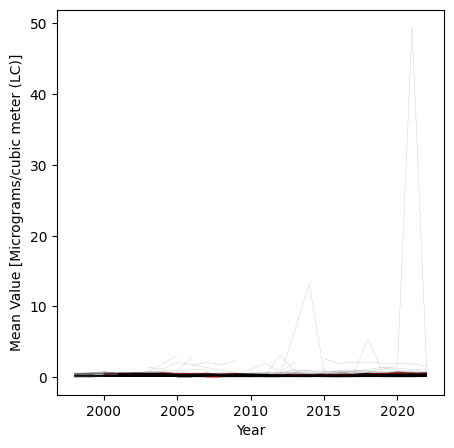

In [22]:
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25_LC.GEOID.unique():
  if i in treatments:
    df = pm25_LC[pm25_LC.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="red", alpha=1, linewidth=0.5)
  else:
    df = pm25_LC[pm25_LC.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="black", alpha=0.25, linewidth=0.25 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [Micrograms/cubic meter (LC)]")

fig.show()
# Notes: the graph doesnt show enough information as is it is in the low value.
# I will use log10 to unpack the values at the bottom

06065 27003 34007 42071 34003 

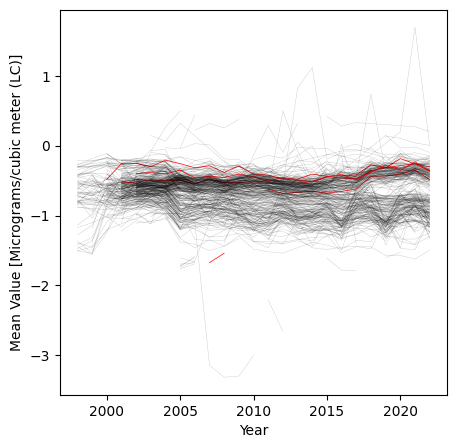

In [42]:
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25_LC.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = pm25_LC[pm25_LC.GEOID == i]
    ax.plot(df.year, np.log10(df["PM2.5_mean"]), color="red", alpha=1, linewidth=0.5)
  else:
    df = pm25_LC[pm25_LC.GEOID == i]
    ax.plot(df.year, np.log10(df["PM2.5_mean"]), color="black", alpha=0.25, linewidth=0.25 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [log of Micrograms/cubic meter (LC)]")

fig.show()

06065 34007 42071 

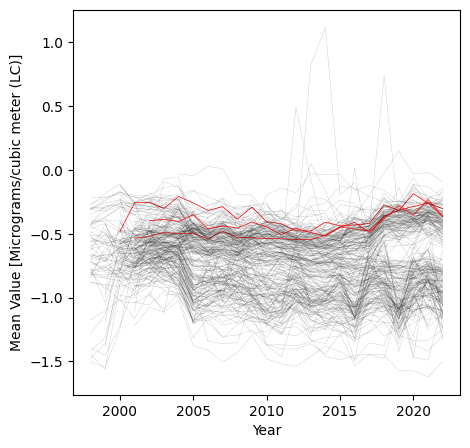

In [65]:
# Getting the GOIDS that had observations for each year
obs = pm25_LC.groupby("GEOID").count().reset_index()[["GEOID", "year"]]
obs = obs.sort_values(by="year", ascending=False).set_index("GEOID")
pm25_LC_mod = pm25_LC.set_index("GEOID").loc[obs["year"] >= 18].reset_index()

# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25_LC_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = pm25_LC_mod[pm25_LC_mod.GEOID == i]
    ax.plot(df.year, np.log10(df["PM2.5_mean"]), color="red", alpha=1, linewidth=0.5)
  else:
    df = pm25_LC_mod[pm25_LC_mod.GEOID == i]
    ax.plot(df.year, np.log10(df["PM2.5_mean"]), color="black", alpha=0.25, linewidth=0.25 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [log of Micrograms/cubic meter (LC)]")

fig.show()

# Notes: for 25 observations there are not treatement counties
# Notes: for 24 observations there are not treatement counties
# For more 23 or more, there is one treatment county 06065; T0 2006
# For 20 or more there are two treatmen counties. 06065 and 42071; T0 2007
# For 18 or more there are three treatment counties. 06065, 42071 and 34007: T0 2003

### Cubic Meter

In [66]:
# I will test the different units of measure to identify the ones that seem more convinient for my analysis.
# Second one is Cubic Meter.
pm25_CM = pd.DataFrame()

for year in range(1998, 2023):
  df = get_PM25(year)
  df = gen_GEOID(df)
  df = gen_year(df)

  df_CM = df[df['Units of Measure'] == 'Cubic meter'].copy()

  # I wont use nanograms
  df_CM = pd.concat([df_CM])
  df_CM = df_CM.drop(columns="Units of Measure")

  df_CM = df_CM.groupby(["GEOID", "year"]).agg(["mean", "std", "max", "min"])
  df_CM.columns = ["_".join(col) for col in df_CM.columns]
  df_CM = df_CM.reset_index()

  pm25_CM = pd.concat([df_CM, pm25_CM])
  print(year, end=" ")

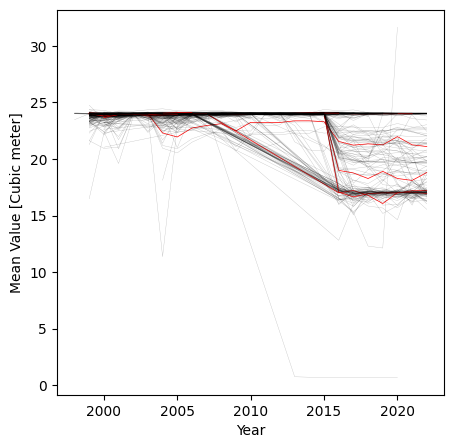

In [69]:
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25_CM.GEOID.unique():
  if i in treatments:
    df = pm25_CM[pm25_CM.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="red", alpha=1, linewidth=0.5)
  else:
    df = pm25_CM[pm25_CM.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="black", alpha=0.25, linewidth=0.25 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [Cubic meter]")

fig.show()

06065 27003 34007 42071 25027 51107 34003 48135 42077 

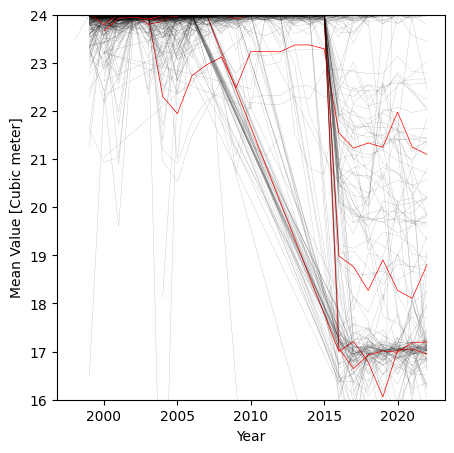

In [71]:
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25_CM.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = pm25_CM[pm25_CM.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="red", alpha=1, linewidth=0.5)
  else:
    df = pm25_CM[pm25_CM.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="black", alpha=0.25, linewidth=0.25 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [Cubic meter]")
ax.set_ylim(16,24)

fig.show()

06065 42071 25027 

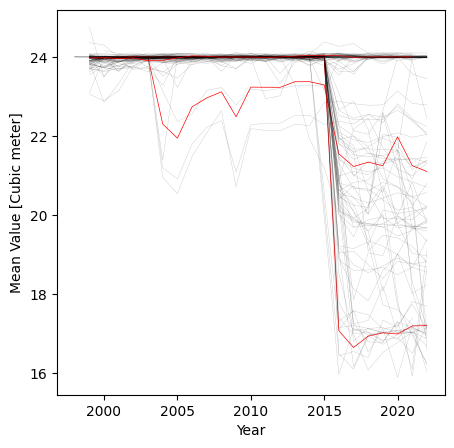

In [75]:
# Getting the GOIDS that had observations for each year
obs = pm25_CM.groupby("GEOID").count().reset_index()[["GEOID", "year"]]
obs = obs.sort_values(by="year", ascending=False).set_index("GEOID")
pm25_CM_mod = pm25_CM.set_index("GEOID").loc[obs["year"] >= 23].reset_index()

# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25_CM_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = pm25_CM_mod[pm25_CM_mod.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="red", alpha=1, linewidth=0.5)
  else:
    df = pm25_CM_mod[pm25_CM_mod.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="black", alpha=0.25, linewidth=0.25 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [Cubic meter]")

fig.show()

# Notes: for 25 observations there are not treatement counties
# For more 24 or more, there is one treatment county 06065; T0 2006
# For 23 or more there are three treatment counties. 06065 and 42071; T0 2007 and 25027; T0 2017

In [76]:
# I will test the different units of measure to identify the ones that seem more convinient for my analysis.
# Third one is Degrees Centigrade.
pm25_DC = pd.DataFrame()

for year in range(1998, 2023):
  df = get_PM25(year)
  df = gen_GEOID(df)
  df = gen_year(df)

  df_DC = df[df['Units of Measure'] == 'Degrees Centigrade'].copy()

  # I wont use nanograms
  df_DC = pd.concat([df_DC])
  df_DC = df_DC.drop(columns="Units of Measure")

  df_DC = df_DC.groupby(["GEOID", "year"]).agg(["mean", "std", "max", "min"])
  df_DC.columns = ["_".join(col) for col in df_DC.columns]
  df_DC = df_DC.reset_index()

  pm25_DC = pd.concat([df_DC, pm25_DC])
  print(year, end=" ")

1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

06065 34007 42071 25027 

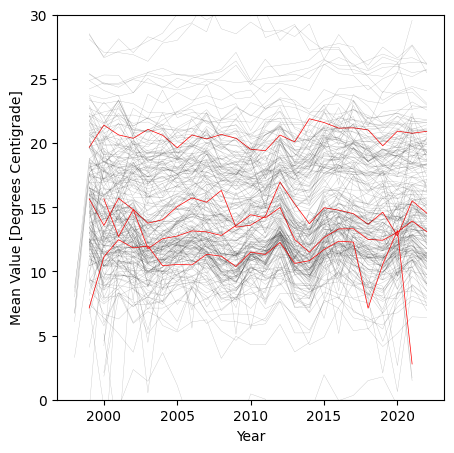

In [87]:
# Getting the GOIDS that had observations for each year
obs = pm25_DC.groupby("GEOID").count().reset_index()[["GEOID", "year"]]
obs = obs.sort_values(by="year", ascending=False).set_index("GEOID")
pm25_DC_mod = pm25_DC.set_index("GEOID").loc[obs["year"] >= 23].reset_index()
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25_DC_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = pm25_DC_mod[pm25_DC_mod.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="red", alpha=1, linewidth=0.5)
  else:
    df = pm25_DC_mod[pm25_DC_mod.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="black", alpha=0.25, linewidth=0.25 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [Degrees Centigrade]")
ax.set_ylim(0,30)

fig.show()

In [88]:
# I will test the different units of measure to identify the ones that seem more convinient for my analysis.
# Forth one is Inverse 100 Megameters.
pm25_IM = pd.DataFrame()

for year in range(1998, 2023):
  df = get_PM25(year)
  df = gen_GEOID(df)
  df = gen_year(df)

  df_IM = df[df['Units of Measure'] == 'Inverse 100 Megameters'].copy()

  # I wont use nanograms
  df_IM = pd.concat([df_IM])
  df_IM = df_IM.drop(columns="Units of Measure")

  df_IM = df_IM.groupby(["GEOID", "year"]).agg(["mean", "std", "max", "min"])
  df_IM.columns = ["_".join(col) for col in df_IM.columns]
  df_IM = df_IM.reset_index()

  pm25_IM = pd.concat([df_IM, pm25_IM])
  print(year, end=" ")

1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

06065 

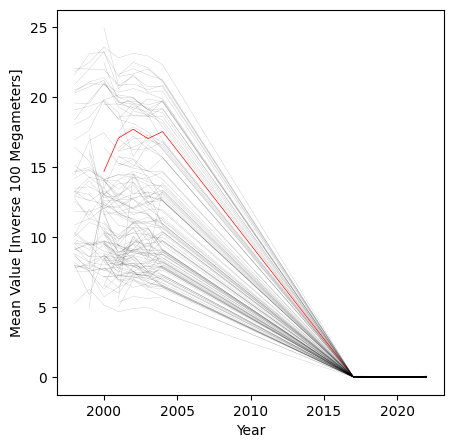

In [91]:
# Getting the GOIDS that had observations for each year
obs = pm25_IM.groupby("GEOID").count().reset_index()[["GEOID", "year"]]
obs = obs.sort_values(by="year", ascending=False).set_index("GEOID")
pm25_IM_mod = pm25_IM.set_index("GEOID").loc[obs["year"] >= 10].reset_index()
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25_IM_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = pm25_IM_mod[pm25_IM_mod.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="red", alpha=1, linewidth=0.5)
  else:
    df = pm25_IM_mod[pm25_IM_mod.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="black", alpha=0.25, linewidth=0.25 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [Inverse 100 Megameters]")
#ax.set_ylim(0,30)

fig.show()

In [95]:
# I will test the different units of measure to identify the ones that seem more convinient for my analysis.
# Fifth one is Millimeters (mercury).
pm25_MM = pd.DataFrame()

for year in range(1998, 2023):
  df = get_PM25(year)
  df = gen_GEOID(df)
  df = gen_year(df)

  df_MM = df[df['Units of Measure'] == 'Millimeters (mercury)'].copy()

  df_MM = pd.concat([df_MM])
  df_MM = df_MM.drop(columns="Units of Measure")

  df_MM = df_MM.groupby(["GEOID", "year"]).agg(["mean", "std", "max", "min"])
  df_MM.columns = ["_".join(col) for col in df_MM.columns]
  df_MM = df_MM.reset_index()

  pm25_MM = pd.concat([df_MM, pm25_MM])
  print(year, end=" ")

1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

06065 34007 42071 25027 

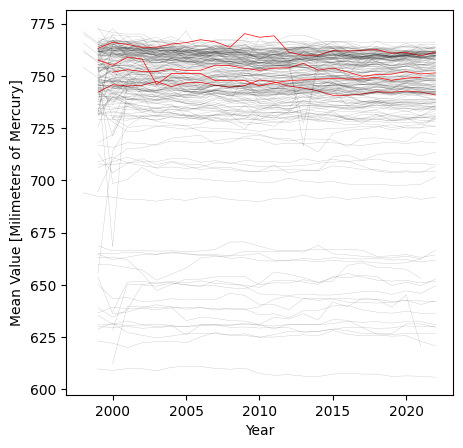

In [121]:
# Getting the GOIDS that had observations for each year
obs = pm25_MM.groupby("GEOID").count().reset_index()[["GEOID", "year"]]
obs = obs.sort_values(by="year", ascending=False).set_index("GEOID")
pm25_MM_mod = pm25_MM.set_index("GEOID").loc[obs["year"] >= 23].reset_index()
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25_MM_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = pm25_MM_mod[pm25_MM_mod.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="red", alpha=1, linewidth=0.5)
  else:
    df = pm25_MM_mod[pm25_MM_mod.GEOID == i]
    ax.plot(df.year, df["PM2.5_mean"], color="black", alpha=0.25, linewidth=0.25 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [Milimeters of Mercury]")
#ax.set_ylim(0,30)

fig.show()

### Percent

In [5]:
# I will test the different units of measure to identify the ones that seem more convinient for my analysis.
# Sixth one is Percentage.
pm25_P = pd.DataFrame()

for year in range(1998, 2023):
  df = get_PM25(year)
  df = gen_GEOID(df)
  df = gen_year(df)

  df_P = df[df['Units of Measure'] == 'Percent'].copy()

  # I wont use nanograms
  df_P = pd.concat([df_P])
  df_P = df_P.drop(columns="Units of Measure")

  df_P = df_P.groupby(["GEOID", "year"]).agg(["mean", "std", "max", "min"])
  df_P.columns = ["_".join(col) for col in df_P.columns]
  df_P = df_P.reset_index()

  pm25_P = pd.concat([df_P, pm25_P])
  print(year, end=" ")

1998 1999 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 

06065 42071 

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


25027 

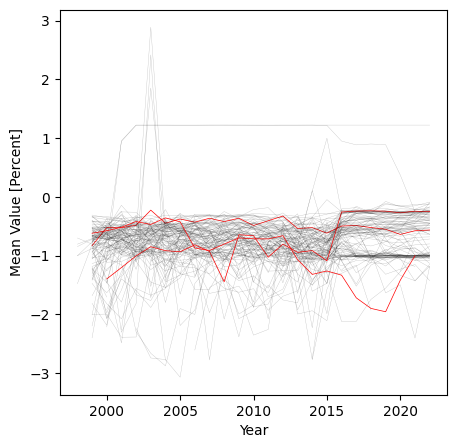

In [9]:
# Getting the GOIDS that had observations for each year
obs = pm25_P.groupby("GEOID").count().reset_index()[["GEOID", "year"]]
obs = obs.sort_values(by="year", ascending=False).set_index("GEOID")
pm25_P_mod = pm25_P.set_index("GEOID").loc[obs["year"] >= 23].reset_index()

# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm25_P_mod.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = pm25_P_mod[pm25_P_mod.GEOID == i]
    ax.plot(df.year, np.log10(df["PM2.5_mean"]), color="red", alpha=1, linewidth=0.5)
  else:
    df = pm25_P_mod[pm25_P_mod.GEOID == i]
    ax.plot(df.year, np.log10(df["PM2.5_mean"]), color="black", alpha=0.25, linewidth=0.25 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [Percent]")
#ax.set_ylim(0,30)

fig.show()

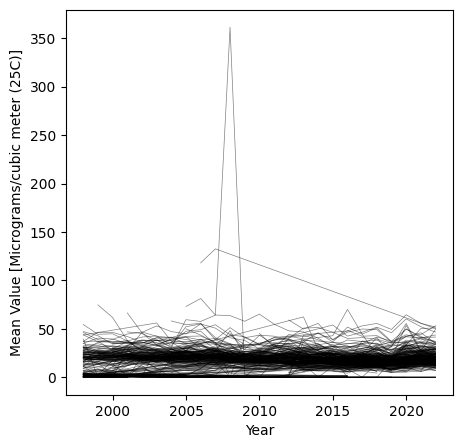

In [ ]:
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm10_25C.GEOID.unique():
  df = pm10_25C[pm10_25C.GEOID == i]
  ax.plot(df.year, df.PM10_mean, color="black", alpha=0.5, linewidth=0.5 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [Micrograms/cubic meter (25C)]")

fig.show()

##PM10

In [ ]:
# This one works
pm10_LC = pd.DataFrame()
pm10_25C = pd.DataFrame()

for year in range(1998, 2023):
  df = get_PM10(year)
  df = gen_GEOID(df)
  df = gen_year(df)

  df_LC_nano = df[df['Units of Measure'] == 'Nanograms/cubic meter (LC)'].copy()
  df_LC_micro = df[df['Units of Measure'] == 'Micrograms/cubic meter (LC)'].copy()
  df_25C_nano = df[df['Units of Measure'] == 'Nanograms/cubic meter (25 C)'].copy()
  df_25C_micro = df[df['Units of Measure'] == 'Micrograms/cubic meter (25 C)'].copy()
  # I wont use nanograms
  df_LC = pd.concat([df_LC_micro])
  df_LC = df_LC.drop(columns="Units of Measure")
  df_25C = pd.concat([df_25C_micro])
  df_25C = df_25C.drop(columns="Units of Measure")

  df_LC = df_LC.groupby(["GEOID", "year"]).agg(["mean", "std", "max", "min"])
  df_LC.columns = ["_".join(col) for col in df_LC.columns]
  df_LC = df_LC.reset_index()

  df_25C = df_25C.groupby(["GEOID", "year"]).agg(["mean", "std", "max", "min"])
  df_25C.columns = ["_".join(col) for col in df_25C.columns]
  df_25C = df_25C.reset_index()

  pm10_LC = pd.concat([df_LC, pm10_LC])
  pm10_25C = pd.concat([df_25C, pm10_25C])


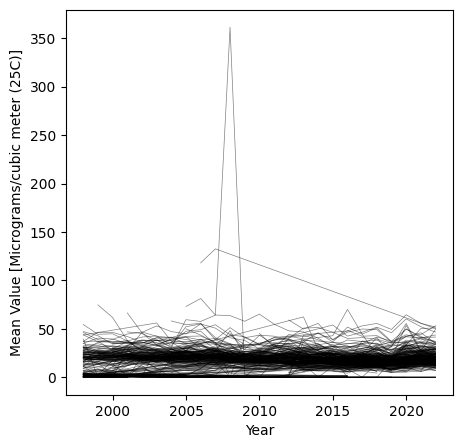

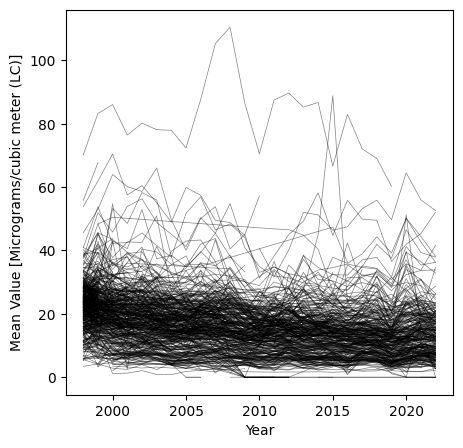

In [ ]:
# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm10_25C.GEOID.unique():
  df = pm10_25C[pm10_25C.GEOID == i]
  ax.plot(df.year, df.PM10_mean, color="black", alpha=0.5, linewidth=0.5 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [Micrograms/cubic meter (25C)]")

fig.show()

# Plotting trends
fig, ax = plt.subplots(figsize=(5,5))

for i in pm10_LC.GEOID.unique():
  df = pm10_LC[pm10_LC.GEOID == i]
  ax.plot(df.year, df.PM10_mean, color="black", alpha=0.5, linewidth=0.5 )

ax.set_xlabel("Year")
ax.set_ylabel("Mean Value [Micrograms/cubic meter (LC)]")

fig.show()

#Descriptive Statistics

In [ ]:
# Removing Non-contiguous counties
for i in ['02', '15', '60', '66', '69', '72', '78', "80"]:

  pm25 = pm25[pm25.GEOID.str[:2] != i]
  pm10 = pm10[pm10.GEOID.str[:2] != i]

In [ ]:
# Save Everything
pm25.to_csv("/content/drive/MyDrive/Disertation/pm25.csv", index=False)
pm10.to_csv("/content/drive/MyDrive/Disertation/pm10.csv", index=False)

In [ ]:
# Import everything
pm25 = pd.read_csv("/content/drive/MyDrive/Disertation/pm25.csv")
print(f"PM2.5 imported ... {len(pm25)} entries")
pm10 = pd.read_csv("/content/drive/MyDrive/Disertation/pm10.csv")
print(f"PM10 imported ... {len(pm10)} entries")
print("......... Completed .........")

AQI imported ... 25785 entries
CO imported ... 5039 entries
NO2 imported ... 6238 entries
Ozone imported ... 18919 entries
SO2 imported ... 8039 entries
PM2.5 imported ... 14551 entries
PM10 imported ... 9943 entries
......... Completed .........


In [ ]:
# Potential Treatment Counties
treatments = ["25027","34003","13151","48329","27003","48135","42071","51107","42077","06065","34007"]